In [1]:
# load libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.special import factorial
from scipy.special import gammaln
from scipy.stats import poisson
from scipy.stats import norm
from tqdm import tqdm
from statsmodels.tsa.statespace.structural import UnobservedComponents
import seaborn as sns

In [2]:
### model selection function
def model_type_SPDK(model, At, params):
    k = 10**7

    # Transition matrices for LL model
    if model == 1:
        Qt = np.array([[params[0]]])
        Ht = At
        Zt = np.array([[1]])
        Tt = np.array([[1]])
        Rt = np.array([[1]])
        ct = np.array([[0]]) # niet relevant voor LL
        P1 = np.array([[k]])
        a1 = np.array([[0]])


    # Transition matrices for AR1
    elif model == 2:
        Qt = np.array([[params[0]]])
        Ht = At
        Zt = np.array([[1]])
        Tt = np.array([[params[1]]]) # phi
        Rt = np.array([[1]])
        ct = np.array([[params[2]]])
        P1 = np.array([[params[0]/(1-(params[1]**2))]]) # unconditional variance
        a1 = np.array([[params[2]/(1-params[1])]]) # unconditional mean


    return Qt, Ht, Zt, Tt, Rt, ct, P1, a1


In [3]:
### KF function
def KF_SPDK(Yt, At, params, model):
    T = len(Yt)
    Qt, Ht, Zt, Tt, Rt, ct, P1, a1 = model_type_SPDK(model=model,At=At, params=params)

    if model == 1:
        # Store recursions for KF 1 state
        a = [np.zeros((1, 1)) for _ in range(T)]
        P = [np.zeros((1, 1)) for _ in range(T)]
        v = [np.zeros((1, 1)) for _ in range(T)]
        F = [np.zeros((1, 1)) for _ in range(T)]
        K = [np.zeros((1, 1)) for _ in range(T)]
            
    if model == 2:
        # Store recursions for KF 1 state
        a = [np.zeros((1, 1)) for _ in range(T)]
        P = [np.zeros((1, 1)) for _ in range(T)]
        v = [np.zeros((1, 1)) for _ in range(T)]
        F = [np.zeros((1, 1)) for _ in range(T)]
        K = [np.zeros((1, 1)) for _ in range(T)]

    for t in range(T):
        at, Pt = (a1, P1) if t == 0 else (Tt @ a[t-1] + K[t-1] @ v[t-1] + ct, 
                                          Tt @ P[t-1] @ Tt.T + Rt @ Qt @ Rt.T - K[t-1] @ F[t-1] @ K[t-1].T)
        vt = Yt[t] - Zt @ at 
        Ft = Zt @ Pt @ Zt.T + Ht[t]
        Kt = Tt @ Pt @ Zt.T @ np.linalg.inv(Ft)
        a[t], P[t], v[t], F[t], K[t] = at, Pt, vt, Ft, Kt

    θkf = Zt @ a
    θkf = θkf.T

    return θkf, a, P, v, F, K
    


In [4]:
### KS function
def KS_SPDK(Yt, At, params, model, a, P, v, F, K):
    T = len(Yt)
    _, _, Zt, Tt, _, _, _, _ = model_type_SPDK(model=model, At=At, params=params)

    # Transition matrices for LL model
    if model == 1:
        # Store recursions of KS
        L = [np.zeros((1, 1)) for _ in range(T)]
        r = [np.zeros((1, 1)) for _ in range(T)]
        N = [np.zeros((1, 1)) for _ in range(T)]
        α = [np.zeros((1, 1)) for _ in range(T)]
        V = [np.zeros((1, 1)) for _ in range(T)]
        
        # Initialize KS
        rt = np.zeros((1, 1))
        Nt = np.zeros((1, 1))
        r[-1] = rt
        N[-1] = Nt

    # Transition matrices for LLT model
    elif model == 2:

        # Store recursions of KS
        L = [np.zeros((1, 1)) for _ in range(T)]
        r = [np.zeros((1, 1)) for _ in range(T)]
        N = [np.zeros((1, 1)) for _ in range(T)]
        α = [np.zeros((1, 1)) for _ in range(T)]
        V = [np.zeros((1, 1)) for _ in range(T)]
        
        # Initialize KS
        rt = np.zeros((1, 1))
        Nt = np.zeros((1, 1))
        r[-1] = rt
        N[-1] = Nt

    # Start recursions
    for t in range(T-1, -1, -1):
        Lt = Tt - K[t] @ Zt
        r_prev = Zt.T @ np.linalg.inv(F[t]) @ v[t] + Lt.T @ rt
        N_prev = Zt.T @ np.linalg.inv(F[t]) @ Zt + Lt.T @ Nt @ Lt
        αt = a[t] + P[t] @ r_prev
        Vt = P[t] - P[t] @ N_prev @ P[t]
        L[t], r[t-1], N[t-1], α[t], V[t] = Lt, r_prev, N_prev, αt, Vt
        rt, Nt = r_prev, N_prev

    θks = Zt @ α
    θks = θks.T

    return θks, L, r, N, α, V

In [5]:
### mode estimation function
def mode_estimation(Yt, params, model):
    At = np.full((len(Yt),), params[1]) #turn At into a vector so we can pass it to KFS
    # get initial guess g
    _, a, P, v, F, K = KF_SPDK(Yt=Yt, At=At, params=params, model=model)
    θks, _, _, _, _, _ = KS_SPDK(Yt=Yt, At=At, params=params, model=model, a=a, P=P, v=v, F=F, K=K)
    initial_g = np.log(θks[0,0])

    # start newton-raphson procedure
    g = initial_g
    tolerance = 1e-7
    max_iterations = 1000
    iteration = 0
    converged = False
    g_values = []
    
    # Initialization
    while not converged and iteration < max_iterations:
        # Obtain z and A based on specific model or data
        At = np.exp(-g)
        z = g + (At*Yt)-1
        
        # Run KFS
        _, a, P, v, F, K = KF_SPDK(Yt=z, At=At, params=params, model=model)
        θks, _, _, _, _, _ = KS_SPDK(Yt=z, At=At, params=params, model=model, a=a, P=P, v=v, F=F, K=K)
        g_plus = θks[0,0]

        # Append the current g value to the list
        g_values.append(g)

        # Check for convergence
        if np.linalg.norm(g_plus - g) < tolerance:
            converged = True
        else:
            g = g_plus
            iteration += 1

    if converged:
        At_final = At
        z_final = z
        mode = g_plus
        # print(f"Succesfully converged to mode after {iteration} iterations.")
        return mode, At_final, z_final, g_values, initial_g
    else:
        print("Max iterations reached without convergence.")
        return None

In [6]:
##### sim smoother function #####
def sim_smoother(z, At, model, params, iterations):
    T = len(z)
    Qt, _, Zt, Tt, Rt, ct, P1, a1 = model_type_SPDK(model=model, At=At, params=params)

    # get theta_hat, the smoothed signal based on approximated observations z and variance At
    _, a, P, v, F, K = KF_SPDK(Yt=z,At=At,model=model,params=params) # apply KF
    theta, _, _, _, _, _ = KS_SPDK(Yt=z, At=At, model=model, params=params, a=a, P=P, v=v, F=F, K=K) # apply KS
    theta=theta[0,0]
    theta_hat = np.tile(theta[:, np.newaxis], (1, iterations))

    # start unconditional simulations
    # matrices to store simulated smoothed states
    theta_hat_plus = np.zeros((T,iterations)) # smoothed unconditional simulation
    theta_plus = np.zeros((T,iterations))
    for m in range(iterations):
        z_plus = np.zeros(T) # vector to store unconditional sim observations

        # initialize unconditional simulation 
        theta_plus[0,m] = np.random.normal(a1,np.sqrt(P1))[0,0]
        z_plus[0] = (Zt@np.array([[theta_plus[0,m]]]) + np.random.normal(0,np.sqrt(At[0])))[0,0]

        for t in range(1,T):
            η_plus = np.array(np.random.normal(0,np.sqrt(Qt))) # simulate error η_plus
            ε_plus = np.array(np.random.normal(0,np.sqrt(At[t]))) # simulate error ε_plus
            theta_plus[t,m] = (Tt@[[theta_plus[t-1,m]]] + Rt@η_plus)[0,0]
            z_plus[t]= (Zt@[[theta_plus[t,m]]] + ε_plus)[0,0] 

        _, a_plus, P_plus, v_plus, F_plus, K_plus = KF_SPDK(Yt=z_plus,At=At,model=model,params=params) # apply KF
        theta_hat_plus_array, _, _, _, _, _ = KS_SPDK(Yt=z_plus, At=At, model=model, params=params, a=a_plus, P=P_plus, v=v_plus, F=F_plus, K=K_plus) # apply KS

        theta_hat_plus[:,m] = theta_hat_plus_array 

    # get conditional smoothed signal
    theta_tilde = theta_hat + theta_plus - theta_hat_plus
    
    return theta_tilde

In [7]:
# custom function to estimate poisson likelihood using exponential family
def log_poisson_exp_family(y, theta):
    return y*theta - np.exp(theta) - gammaln(y + 1)

# weights function Poisson
def weights_poisson(Yt, z, At, theta_tilde):
    log_poisson_likelihoods = log_poisson_exp_family(Yt[:, None], theta_tilde)
    joint_log_poisson_likelihood = np.sum(log_poisson_likelihoods, axis=0)
    log_gaussian_likelihoods = norm.logpdf(z[:, None], loc=theta_tilde, scale=np.sqrt(At[:, None]))
    joint_log_gaussian_likelihood = np.sum(log_gaussian_likelihoods, axis=0)

    mi = joint_log_poisson_likelihood - joint_log_gaussian_likelihood
    m_bar = np.mean(mi)

    return mi, m_bar, joint_log_poisson_likelihood, joint_log_gaussian_likelihood

In [8]:
# logl function
def logl_SPDK(Yt, params, model, M):

    # get approximating model
    _, At, z, _, _ = mode_estimation(Yt=Yt, params=params, model=model)

    # KF function
    _, _, _, v, F, *_ = KF_SPDK(Yt=z, At=At, params=params, model=model)
    v = np.array(v)[:,0][:,0]
    F = np.array(F)[:,0][:,0]

    # Sim smoother
    theta_tilde = sim_smoother(z=z, At=At, model=model, params=params, iterations=M)

    # Weights function - Poisson
    mi, m_bar, _, _ = weights_poisson(Yt=Yt, z=z, At=At, theta_tilde=theta_tilde)

    # compute log_g
    # Using numpy's broadcasting to compute the log determinant and the quadratic form at once
    log_g = -0.5*np.log(2*np.pi) - 0.5*(np.log(F) + v**2/F)
    if model == 1:
        log_g[0] = -(1/2) * np.log(2 * np.pi) # diffuse

    # Compute total logl
    logl = np.sum(log_g) + m_bar - np.log(M) + np.log(np.sum(np.exp(mi - m_bar)))
        
    return np.mean(-logl)

In [9]:
#mle SPDK
def mle_SPDK(Yt, params0, model, M):
    # Convert initial parameters to their log-values
    trans_params0 = np.log(params0)
    
    def logl_wrapper(trans_params):
        # Transform parameters back to their original space
        original_params = np.exp(trans_params)
        # Print or log the parameters 
        print("Parameters:", original_params)
        return logl_SPDK(Yt, original_params, model, M)
        
    result = minimize(fun=logl_wrapper, 
                      x0=trans_params0, 
                      method='Nelder-Mead', 
                      options={'maxfev': 100})
    return np.exp(result.x)
    
# mle_params = mle_SPDK(Yt, params0, model, M)

In [10]:
# conditional_mean estimation
def IS_conditional_mean(theta_tilde, mi, m_bar):    
    xi = theta_tilde
    weights = np.exp(mi - m_bar)
    numerator_terms = xi * weights
    denominator = np.sum(weights)
    x_hat = np.sum(numerator_terms, axis=1) / denominator

    return x_hat

In [11]:
### model selection function
def model_type(model, params):
    k = 10**7

    # Transition matrices for LL model
    if model == 1:
        Qt = np.array([[params[0]]])
        Ht = np.array([[params[1]]])
        Zt = np.array([[1]])
        Tt = np.array([[1]])
        Rt = np.array([[1]])
        ct = np.array([[0]]) # niet relevant voor LL
        P1 = np.array([[k]])
        a1 = np.array([[0]])


    # Transition matrices for AR1
    elif model == 2:
        Qt = np.array([[params[0]]])
        Ht = np.array([[params[1]]])
        Zt = np.array([[1]])
        Tt = np.array([[params[2]]]) # phi
        Rt = np.array([[1]])
        ct = np.array([[params[3]]])
        P1 = np.array([[params[0]/(1-(params[2]**2))]]) # unconditional variance
        a1 = np.array([[params[3]/(1-params[2])]]) # unconditional mean


    return Qt, Ht, Zt, Tt, Rt, ct, P1, a1


In [12]:
### KF function
def KF(Yt, params, model):
    T = len(Yt)
    Qt, Ht, Zt, Tt, Rt, ct, P1, a1 = model_type(model=model,params=params)

    if model == 1:
        # Store recursions for KF 1 state
        a = [np.zeros((1, 1)) for _ in range(T)]
        P = [np.zeros((1, 1)) for _ in range(T)]
        v = [np.zeros((1, 1)) for _ in range(T)]
        F = [np.zeros((1, 1)) for _ in range(T)]
        K = [np.zeros((1, 1)) for _ in range(T)]
            
    if model == 2:
        # Store recursions for KF 1 state
        a = [np.zeros((1, 1)) for _ in range(T)]
        P = [np.zeros((1, 1)) for _ in range(T)]
        v = [np.zeros((1, 1)) for _ in range(T)]
        F = [np.zeros((1, 1)) for _ in range(T)]
        K = [np.zeros((1, 1)) for _ in range(T)]

    for t in range(T):
        at, Pt = (a1, P1) if t == 0 else (Tt @ a[t-1] + K[t-1] @ v[t-1] + ct, 
                                          Tt @ P[t-1] @ Tt.T + Rt @ Qt @ Rt.T - K[t-1] @ F[t-1] @ K[t-1].T)
        vt = Yt[t] - Zt @ at 
        Ft = Zt @ Pt @ Zt.T + Ht
        Kt = Tt @ Pt @ Zt.T @ np.linalg.inv(Ft)
        a[t], P[t], v[t], F[t], K[t] = at, Pt, vt, Ft, Kt

    θkf = Zt @ a
    θkf = θkf.T

    return θkf, a, P, v, F, K
    


In [13]:
### KS function
def KS(Yt, params, model, a, P, v, F, K):
    T = len(Yt)
    _, _, Zt, Tt, _, _, _, _ = model_type(model=model,params=params)

    # Transition matrices for LL model
    if model == 1:
        # Store recursions of KS
        L = [np.zeros((1, 1)) for _ in range(T)]
        r = [np.zeros((1, 1)) for _ in range(T)]
        N = [np.zeros((1, 1)) for _ in range(T)]
        α = [np.zeros((1, 1)) for _ in range(T)]
        V = [np.zeros((1, 1)) for _ in range(T)]
        
        # Initialize KS
        rt = np.zeros((1, 1))
        Nt = np.zeros((1, 1))
        r[-1] = rt
        N[-1] = Nt

    # Transition matrices for LLT model
    elif model == 2:

        # Store recursions of KS
        L = [np.zeros((1, 1)) for _ in range(T)]
        r = [np.zeros((1, 1)) for _ in range(T)]
        N = [np.zeros((1, 1)) for _ in range(T)]
        α = [np.zeros((1, 1)) for _ in range(T)]
        V = [np.zeros((1, 1)) for _ in range(T)]
        
        # Initialize KS
        rt = np.zeros((1, 1))
        Nt = np.zeros((1, 1))
        r[-1] = rt
        N[-1] = Nt

    # Start recursions
    for t in range(T-1, -1, -1):
        Lt = Tt - K[t] @ Zt
        r_prev = Zt.T @ np.linalg.inv(F[t]) @ v[t] + Lt.T @ rt
        N_prev = Zt.T @ np.linalg.inv(F[t]) @ Zt + Lt.T @ Nt @ Lt
        αt = a[t] + P[t] @ r_prev
        Vt = P[t] - P[t] @ N_prev @ P[t]
        L[t], r[t-1], N[t-1], α[t], V[t] = Lt, r_prev, N_prev, αt, Vt
        rt, Nt = r_prev, N_prev

    θks = Zt @ α
    θks = θks.T

    return θks, L, r, N, α, V

In [14]:
### logl function
def logl(Yt, params, model):
    # Call KF function
    _, _, _, v, F, *_ = KF(Yt=Yt, params=params, model=model)
    
    # Using numpy's broadcasting to compute the log determinant and the quadratic form at once
    log_dets = -0.5 * np.log(np.linalg.det(F))
    quad_forms = -0.5 * np.array([vt.T @ np.linalg.inv(Ft) @ vt for vt, Ft in zip(v, F)]).squeeze()

    # Computing the log likelihoods
    logl = -(0.5 * np.log(2 * np.pi)) + log_dets + quad_forms
    if model == 1:
        logl[0] = -(1/2) * np.log(2 * np.pi) # diffuse
    
    return -logl.mean()

In [15]:
#### MLE function new
def mle(Yt, params0, model):
    trans_params0 = np.log(params0)
    
    def logl_wrapper(trans_params):
        # Transform parameters back to their original space
        original_params = np.exp(trans_params)
        # Print or log the parameters 
        print("Parameters:", original_params)
        return logl(Yt, original_params, model)
        
    result = minimize(fun=logl_wrapper, 
                      x0=trans_params0, 
                      method='Nelder-Mead', 
                    #   options={'maxfev': 200}
                      )

    return np.exp(result.x)
    

In [16]:
# conditional_variance estimation
def IS_conditional_variance(theta_tilde, mi, m_bar, x_hat):    
    xi = theta_tilde
    xi2 = xi**2
    weights = np.exp(mi - m_bar)
    numerator_terms = xi2 * weights
    denominator = np.sum(weights)
    x_var1 = np.sum(numerator_terms, axis=1) / denominator
    x_var = x_var1 - x_hat**2

    return x_var

#### load data

In [17]:
y1 = np.loadtxt('CLO_extreme_neerslag.csv', delimiter=',', skiprows=1, usecols=1)


#### SPDK mle

In [18]:
np.random.seed(1)
Qt0 = 0.05
At0 = np.mean(y1, axis=0)
params0 = [Qt0,At0]
Y=y1
model=1
M=100

# # # Collect optimized parameters for each Y
mle_SPDK_y1 = mle_SPDK(Yt=Y, params0=params0, model=model, M=M)

Parameters: [0.05       6.48611111]
Parameters: [0.04304458 6.48611111]
Parameters: [0.05       7.12169882]
Parameters: [0.04304458 7.12169882]
Parameters: [0.03993859 7.46248056]
Parameters: [0.0343828  6.79647923]
Parameters: [0.02851195 6.63948186]
Parameters: [0.0264546  7.63893857]
Parameters: [0.02073922 8.29005352]
Parameters: [0.01480562 7.37578605]
Parameters: [0.00901454 7.33281721]
Parameters: [6.55705820e-03 9.15575167e+00]
Parameters: [3.14448927e-03 1.07516202e+01]
Parameters: [1.36678798e-03 9.51015155e+00]
Parameters: [2.69757777e-03 9.18924672e+00]
Parameters: [9.40980483e-04 1.34735788e+01]
Parameters: [5.12392496e-03 8.53736572e+00]
Parameters: [5.97281282e-03 9.98890510e+00]
Parameters: [4.89640882e-03 9.78269229e+00]
Parameters: [0.00797867 7.76798478]
Parameters: [3.96867163e-03 9.91248461e+00]
Parameters: [6.32172014e-03 8.42557896e+00]
Parameters: [4.45854025e-03 9.51780566e+00]
Parameters: [4.26056900e-03 1.09061468e+01]
Parameters: [4.46171055e-03 1.02585145e+

#### signal extraction SPDK

In [19]:
np.random.seed(1)
model=1
iterations=100
Yt = y1
params=mle_SPDK_y1

mode, At, z, g_values, initial_g = mode_estimation(Yt, params, model)
theta_tilde = sim_smoother(z=z, At=At, model=model, params=params, iterations=iterations)
mi, m_bar, joint_log_poisson_likelihood, joint_log_gaussian_likelihood = weights_poisson(Yt=Yt, z=z, At=At, theta_tilde=theta_tilde)
x_hat = IS_conditional_mean(theta_tilde, mi, m_bar)
x_var = IS_conditional_variance(theta_tilde, mi, m_bar, x_hat)
theta_hat = x_hat
theta_var = x_var

mode_1 = mode
At_1 = At
z_1 = z
g_values_1 = g_values
theta_tilde_1 = theta_tilde
weight_1 = np.exp(mi - m_bar)
signal_SPDK_1 = theta_hat
var_SPDK_1 = theta_var

#### KFS mle

In [20]:
# find MLE estimates for first simulation
# Set initial parameters
Y=y1

#use of initial variance of signal
exp_θ = np.exp(signal_SPDK_1)  # exponent of SPDK signal
# Calculate the differences between each time points for each simulation
diff = np.diff(exp_θ, axis=0)
# Square the differences
squared_diff = diff ** 2

Qt0 = np.mean(squared_diff , axis=0) # set mean squared difference
At0 = np.mean(Y, axis=0) # set equal to mean of observations
params0 = [Qt0, At0]
model=1

# Collect optimized parameters for each Y
mle_KFS_y1 = np.array(mle(Yt=Y, params0=params0, model=model))


Parameters: [0.01719882 6.48611111]
Parameters: [0.01403697 6.48611111]
Parameters: [0.01719882 7.12169882]
Parameters: [0.02107287 7.12169882]
Parameters: [0.02581955 7.46248056]
Parameters: [0.02581955 8.19374478]
Parameters: [0.03163543 9.20940254]
Parameters: [0.04749238 9.65008338]
Parameters: [ 0.07891991 11.23323377]
Parameters: [ 0.05819008 11.90911006]
Parameters: [ 0.04749238 10.59571541]
Parameters: [ 0.07129746 11.10273296]
Parameters: [ 0.07129746 10.11185132]
Parameters: [0.08735728 9.8782695 ]
Parameters: [0.05819008 8.58582519]
Parameters: [0.1070346  8.78884583]
Parameters: [0.16068463 8.38749428]
Parameters: [0.24122621 9.65008338]
Parameters: [0.4437105  8.19374478]
Parameters: [0.13114426 9.42716831]
Parameters: [0.08735728 8.19374478]
Parameters: [0.1070346 7.2900987]
Parameters: [0.12465021 8.84034671]
Parameters: [0.22928108 9.04938577]
Parameters: [0.18013618 8.82744326]
Parameters: [0.23221073 8.37525182]
Parameters: [0.14562647 8.72170598]
Parameters: [0.12990

#### KFS signal extraction

In [21]:
model=1
Yt = y1
params0 = mle_KFS_y1
θkf, a, P, v, F, K = KF(Yt, params0, model)
signal_KFS, L, r, N, α, V = KS(Yt, params0, model, a, P, v, F, K)

var_KFS_1 = V 
signal_KFS_1 = signal_KFS

#### Confidence bounds

In [22]:
UB_SPDK_1 = signal_SPDK_1 + 2*np.sqrt(var_SPDK_1)
LB_SPDK_1 = signal_SPDK_1 - 2*np.sqrt(var_SPDK_1)
UB_KFS_1 = signal_KFS_1[0,0] + 2*np.sqrt(np.array(var_KFS_1)[:,0,0])
LB_KFS_1 = signal_KFS_1[0,0] - 2*np.sqrt(np.array(var_KFS_1)[:,0,0])

#### plots

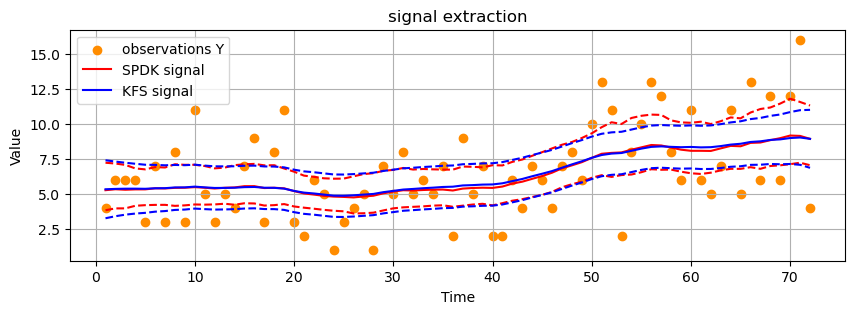

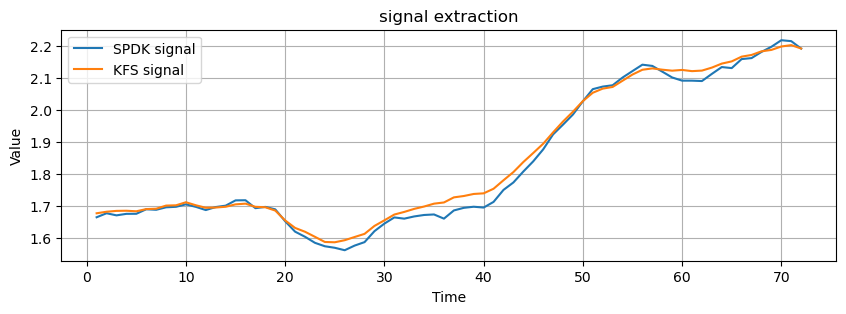

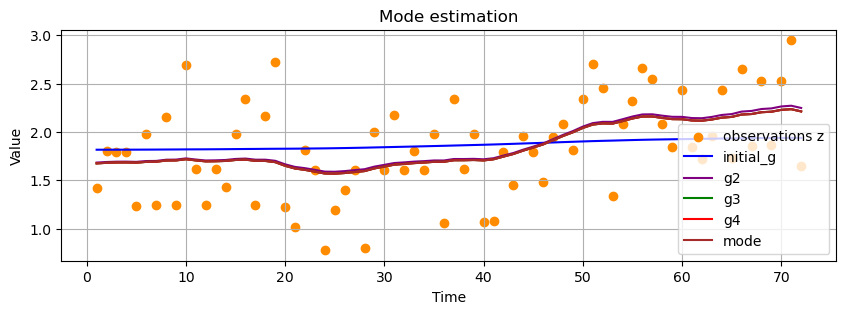

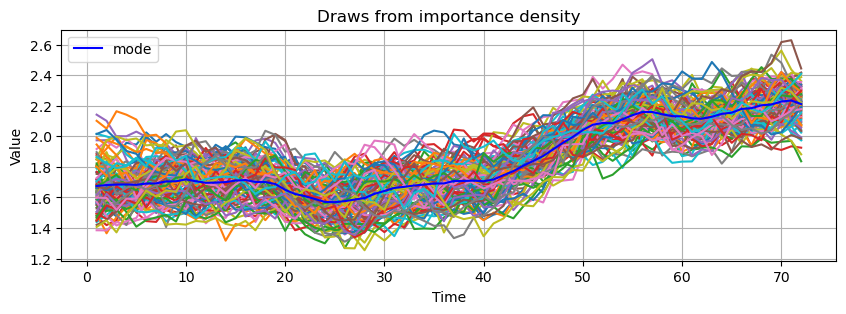

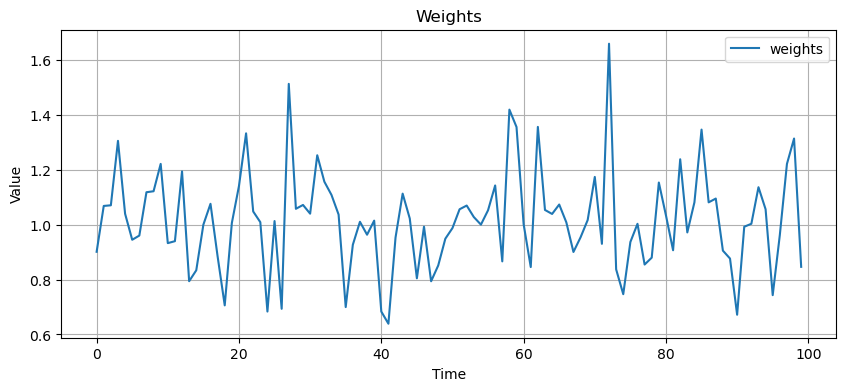

In [25]:
Yt = y1
size = len(Yt)
x = np.arange(1, size + 1)

plt.figure(figsize=(10, 3))
plt.scatter(x, Yt, label='observations Y', color='darkorange')
plt.plot(x, np.exp(signal_SPDK_1), label='SPDK signal', color='red')
plt.plot(x, np.exp(UB_SPDK_1),color='red', linestyle='dashed')
plt.plot(x, np.exp(LB_SPDK_1),color='red', linestyle='dashed')
plt.plot(x, signal_KFS_1[0,0], label='KFS signal', color='blue')
plt.plot(x, UB_KFS_1,color='blue', linestyle='dashed')
plt.plot(x, LB_KFS_1,color='blue', linestyle='dashed')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('signal extraction')
plt.grid()
plt.legend()
plt.show()

plt.figure(figsize=(10, 3))
# plt.scatter(x, Yt, label='observations Y', color='darkorange')
plt.plot(x, signal_SPDK_1, label='SPDK signal')
plt.plot(x, np.log(signal_KFS_1[0,0]), label='KFS signal')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('signal extraction')
plt.grid()
plt.legend()
plt.show()

# First separate plot (Logged values)
plt.figure(figsize=(10, 3))
plt.scatter(x, z_1, label='observations z', color='darkorange')
plt.plot(x, np.array(g_values_1)[0], label='initial_g', color='blue')
plt.plot(x, np.array(g_values_1)[1], label='g2', color='purple')
plt.plot(x, np.array(g_values_1)[2], label='g3', color='green')
plt.plot(x, np.array(g_values_1)[3], label='g4', color='red')
plt.plot(x, mode_1, label='mode', color='brown')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Mode estimation')
plt.grid()
plt.legend()
plt.show()  # This will display the first plot

# Create plot for 1 time series
x = np.arange(1, size + 1)
plt.figure(figsize=(10, 3))
plt.plot(x, theta_tilde_1)
plt.plot(x, mode_1, color='blue', label='mode')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Draws from importance density')
plt.grid()
plt.legend()
plt.show()

# Create plot for 1 time series
plt.figure(figsize=(10, 4))
plt.plot(weight_1, label='weights')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Weights')
plt.grid()
plt.legend()
plt.show()


### final plots

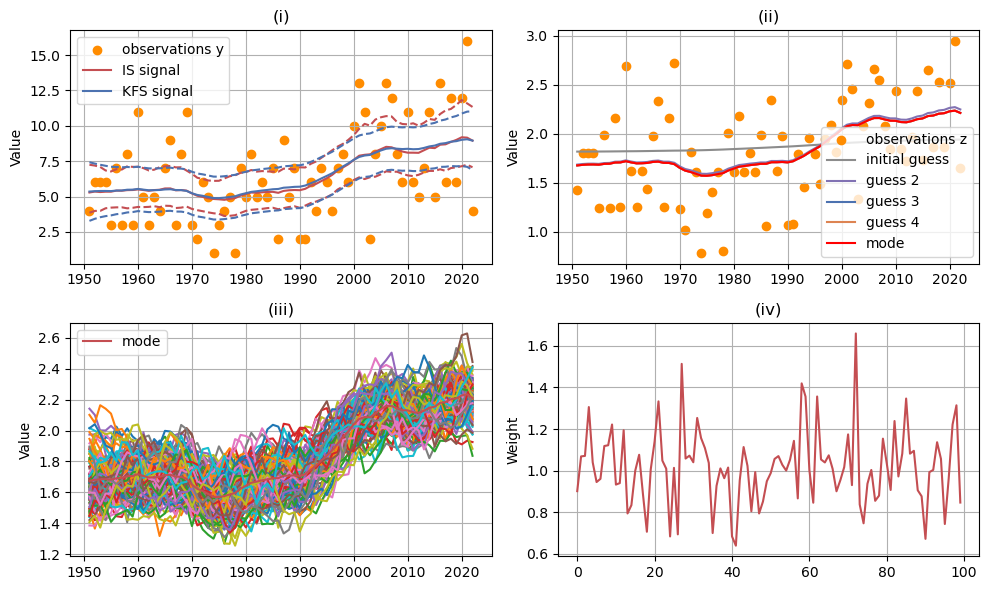

In [49]:
Yt = y1
size = len(Yt)
x = np.arange(1951, 1951 + size)

fig, axs = plt.subplots(2, 2, figsize=(10, 6))

# First plot
axs[0, 0].scatter(x, Yt, label='observations y', color='darkorange')
axs[0, 0].plot(x, np.exp(signal_SPDK_1), label='IS signal', color='#c44e52')
axs[0, 0].plot(x, np.exp(UB_SPDK_1), color='#c44e52', linestyle='dashed')
axs[0, 0].plot(x, np.exp(LB_SPDK_1), color='#c44e52', linestyle='dashed')
axs[0, 0].plot(x, signal_KFS_1[0, 0], label='KFS signal', color='#4c72b0')
axs[0, 0].plot(x, UB_KFS_1, color='#4c72b0', linestyle='dashed')
axs[0, 0].plot(x, LB_KFS_1, color='#4c72b0', linestyle='dashed')
axs[0, 0].set_ylabel('Value')
axs[0, 0].set_title('(i)')
axs[0, 0].grid()
axs[0, 0].legend()

# Third plot
axs[0, 1].scatter(x, z_1, label='observations z', color='darkorange')
axs[0, 1].plot(x, np.array(g_values_1)[0], label='initial guess', color='#8c8c8c')
axs[0, 1].plot(x, np.array(g_values_1)[1], label='guess 2', color='#8172b3')
axs[0, 1].plot(x, np.array(g_values_1)[2], label='guess 3', color='#4c72b0')
axs[0, 1].plot(x, np.array(g_values_1)[3], label='guess 4', color='#dd8452')
axs[0, 1].plot(x, mode_1, label='mode', color='red')
axs[0, 1].set_ylabel('Value')
axs[0, 1].set_title('(ii)')
axs[0, 1].grid()
axs[0, 1].legend()

# Fourth plot
axs[1, 0].plot(x, theta_tilde_1)
axs[1, 0].plot(x, mode_1, color='#c44e52', label='mode')
axs[1, 0].set_ylabel('Value')
axs[1, 0].set_title('(iii)')
axs[1, 0].grid()
axs[1, 0].legend()

# Second plot
axs[1, 1].plot(weight_1, color = '#c44e52', label='weights')
axs[1, 1].set_ylabel('Weight')
axs[1, 1].set_title('(iv)')
axs[1, 1].grid()

plt.tight_layout()
plt.show()


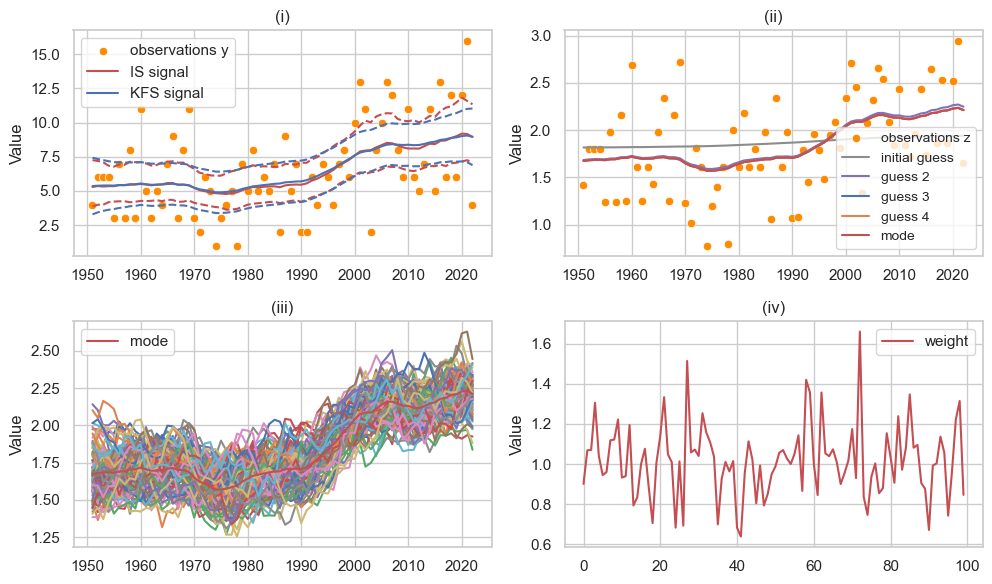

In [71]:
sns.set_theme(style="whitegrid")

fig, axs = plt.subplots(2, 2, figsize=(10, 6))

# Plotting 
sns.scatterplot(x=x, y=Yt, ax=axs[0, 0], color='darkorange', label='observations y')
sns.lineplot(x=x, y=np.exp(signal_SPDK_1), ax=axs[0, 0], color='#c44e52', label='IS signal')
sns.lineplot(x=x, y=np.exp(UB_SPDK_1), ax=axs[0, 0], color='#c44e52', linestyle='dashed')
sns.lineplot(x=x, y=np.exp(LB_SPDK_1), ax=axs[0, 0], color='#c44e52', linestyle='dashed')
sns.lineplot(x=x, y=signal_KFS_1[0, 0], ax=axs[0, 0], color='#4c72b0', label='KFS signal')
sns.lineplot(x=x, y=UB_KFS_1, ax=axs[0, 0], color='#4c72b0', linestyle='dashed')
sns.lineplot(x=x, y=LB_KFS_1, ax=axs[0, 0], color='#4c72b0', linestyle='dashed')
axs[0, 0].set_ylabel('Value')
axs[0, 0].set_title('(i)')

sns.scatterplot(x=x, y=z_1, ax=axs[0, 1], color='darkorange', label='observations z')
sns.lineplot(x=x, y=np.array(g_values_1)[0], ax=axs[0, 1], color='#8c8c8c', label='initial guess')
sns.lineplot(x=x, y=np.array(g_values_1)[1], ax=axs[0, 1], color='#8172b3', label='guess 2')
sns.lineplot(x=x, y=np.array(g_values_1)[2], ax=axs[0, 1], color='#4c72b0', label='guess 3')
sns.lineplot(x=x, y=np.array(g_values_1)[3], ax=axs[0, 1], color='#dd8452', label='guess 4')
sns.lineplot(x=x, y=mode_1, ax=axs[0, 1], color= '#c44e52', label='mode')
axs[0, 1].set_ylabel('Value')
axs[0, 1].set_title('(ii)')
axs[0, 1].legend(fontsize='small')

for i in range(theta_tilde_1.shape[1]):
    sns.lineplot(x=x, y=theta_tilde_1[:, i], ax=axs[1, 0], legend=False)
sns.lineplot(x=x, y=mode_1, ax=axs[1, 0], color='#c44e52', label='mode')
axs[1, 0].set_ylabel('Value')
axs[1, 0].set_title('(iii)')

sns.lineplot(x=np.arange(len(weight_1)), y=weight_1, ax=axs[1, 1], color='#c44e52', label='weight')
axs[1, 1].set_ylabel('Value')
axs[1, 1].set_title('(iv)')

plt.tight_layout()
plt.show()


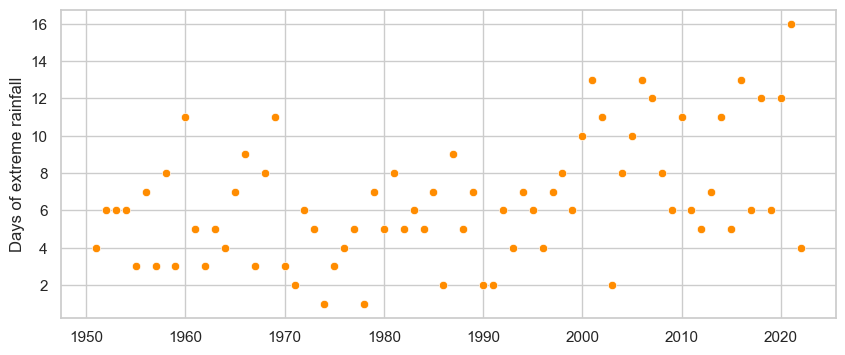

In [80]:
sns.set_theme(style="whitegrid")
plt.figure(figsize=(10, 4))
sns.scatterplot(x=x, y=Yt, color='darkorange')
plt.ylabel('Days of extreme rainfall')
plt.show()

In [87]:
print(np.mean(Yt))
print(np.median(Yt))
print(np.min(Yt))
print(np.max(Yt))
print(np.std(Yt))

6.486111111111111
6.0
1.0
16.0
3.2744509953559624


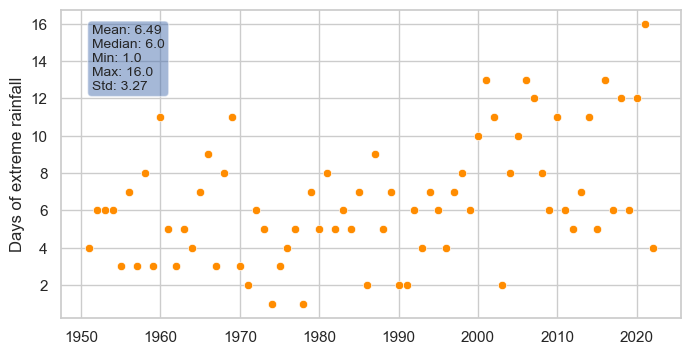

In [89]:
mean_yt = np.mean(Yt)
median_yt = np.median(Yt)
min_yt = np.min(Yt)
max_yt = np.max(Yt)
std_yt = np.std(Yt)

sns.set_theme(style="whitegrid")
plt.figure(figsize=(8, 4))
sns.scatterplot(x=x, y=Yt, color='darkorange')
plt.ylabel('Days of extreme rainfall')

desc_text = f'Mean: {mean_yt:.2f}\nMedian: {median_yt}\nMin: {min_yt}\nMax: {max_yt}\nStd: {std_yt:.2f}'
plt.text(0.05, 0.95, desc_text, transform=plt.gca().transAxes, fontsize=10, verticalalignment='top', bbox=dict(boxstyle="round", alpha=0.5))

plt.show()

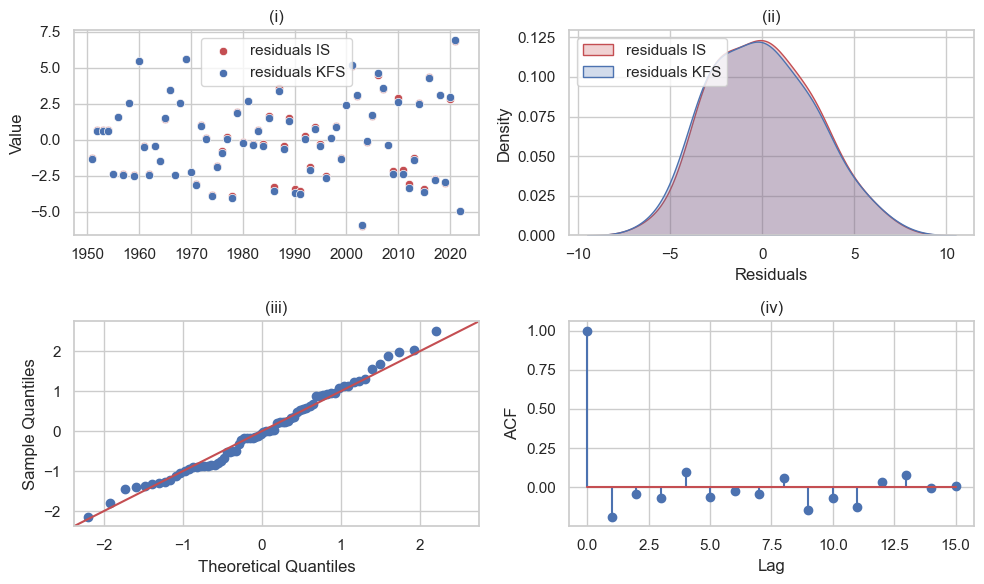

In [122]:
import statsmodels.api as sm
from statsmodels.tsa.stattools import acf

SPDK_res = Yt - np.exp(signal_SPDK_1)
KFS_res = Yt - signal_KFS_1[0, 0]

sns.set_theme(style="whitegrid")

fig, axs = plt.subplots(2, 2, figsize=(10, 6))

# Plotting 
sns.scatterplot(x=x, y=SPDK_res, ax=axs[0, 0], color='#c44e52', label='residuals IS')
sns.scatterplot(x=x, y=KFS_res, ax=axs[0, 0], color='#4c72b0', label='residuals KFS')
axs[0, 0].set_ylabel('Value')
axs[0, 0].set_title('(i)')

sns.kdeplot(SPDK_res, ax=axs[0, 1], shade=True, label='residuals IS', color='#c44e52', bw_adjust=1)
sns.kdeplot(KFS_res, ax=axs[0, 1], shade=True, label='residuals KFS', color='#4c72b0', bw_adjust=1)
axs[0, 1].set_title('(ii)')
axs[0, 1].legend(loc='upper left')
axs[0, 1].set_ylabel('Density')
axs[0, 1].set_xlabel('Residuals')

KFS_res_standardized = (KFS_res - np.mean(KFS_res)) / np.std(KFS_res)
sm.qqplot(KFS_res_standardized, line ='45', ax=axs[1, 0])
axs[1, 0].set_title('(iii)')

lag_acf = acf(KFS_res, nlags=15)
axs[1, 1].stem(range(len(lag_acf)), lag_acf, use_line_collection=True)
axs[1, 1].set_title('(iv)')
axs[1, 1].set_xlabel('Lag')
axs[1, 1].set_ylabel('ACF')

plt.tight_layout()
plt.show()
